In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [2]:
plt.rcParams['font.family'] = 'sans-serif'

# Helper functions

In [3]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [4]:
def smooth(xs, ys, degree=8):
    poly = np.polyfit(xs, ys, degree)
    poly_y = np.poly1d(poly)(xs)
    return poly_y

def smooth(xs, ys):
    from scipy.signal import lfilter
    n = 5             # larger n gives smoother curves
    b = [1.0 / n] * n  # numerator coefficients
    a = 1              # denominator coefficient
    y_lf = lfilter(b, a, ys)
    return y_lf

def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

In [67]:
def get_df(base, z, pfiles, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': []}
    task_dir = f'{base}_{net_yaml}_dim{z}'
    task_dir = f'{engram_dir}pickles/{task_dir}/'
    if not os.path.exists(task_dir): return
    for pickle_file in pfiles:
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_score = results['valid_score']
        valid_steps = results['valid_steps_per_ep']
        episode = results['episode']
        model = results['model']
        step = results['step']
        for i in range(len(valid_score)):
            if valid_score[i] == None: continue
            data['valid_score'].append(valid_score[i])
            data['valid_steps'].append(valid_steps[i])
            data['dims'].append(z)
            data['episode'].append(episode[i])
            _model = model[i].split(base+'_')[-1]
            data['model'].append(_model)
            data['z'].append(z)
            data['step'].append(step[i])
    df = pd.DataFrame(data)
    return df

# Experiment

In [146]:
base = 'frozentransfer_gridworld8x8'
net_yaml = 'dm'
z = 10

In [147]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [148]:
np.unique(df['model'])

array(['entro_0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0_-2_entro0'],
      dtype=object)

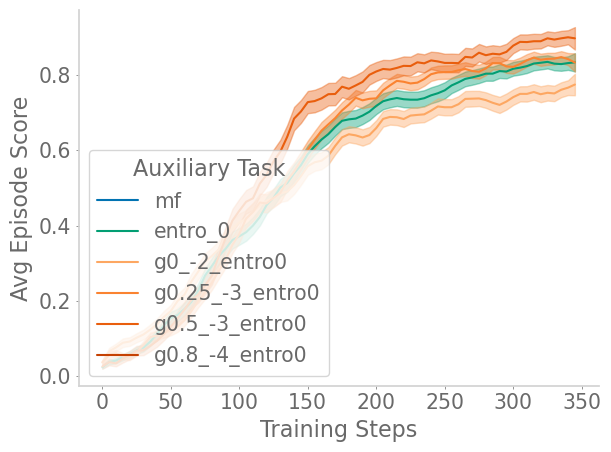

In [149]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    #np.unique(new_df['model'])
    ['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']
    #['mf_2', 'mf_-1', 'mf', 'mf_1', 'mf_2', 'mf_3']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [166]:
base = 'tmp'
net_yaml = 'dm_large_encoder'
z = 4

In [167]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [168]:
np.unique(df['model'])

array(['entro-1', 'entro1', 'entro_0', 'g0.25_-3_entro0',
       'g0.5_-3_entro0', 'g0.8_-4_entro0', 'g0_-2_entro0'], dtype=object)

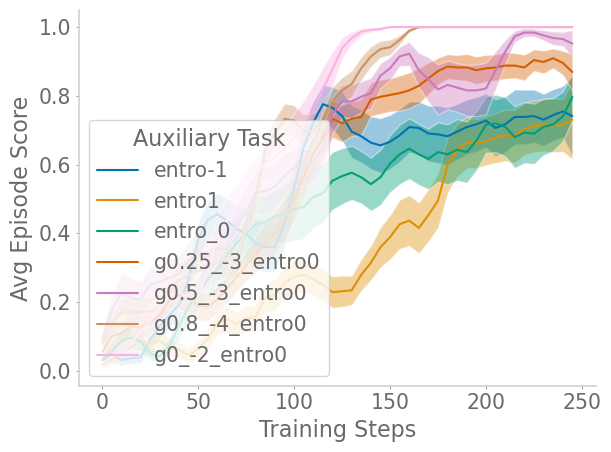

In [169]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    np.unique(new_df['model'])
    #['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']
    #['mf_2', 'mf_-1', 'mf', 'mf_1', 'mf_2', 'mf_3']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model)#, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4#, color=colors[_idx]
        )
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [95]:
base = 'altT_eps0.4_tlen8'
net_yaml = 'dm'
z = 16

In [96]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [97]:
np.unique(df['model'])

array(['g0_-2_entro0', 'mf'], dtype=object)

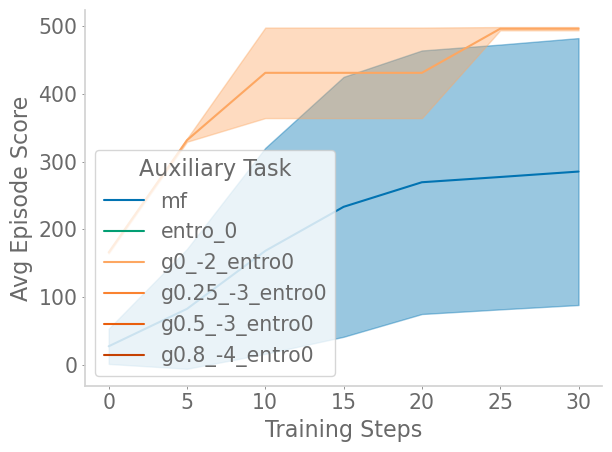

In [98]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    #np.unique(new_df['model'])
    ['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']
    #['mf_2', 'mf_-1', 'mf', 'mf_1', 'mf_2', 'mf_3']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()

# Experiment

In [154]:
base = 'fulltransfer_gridworld8x8_-3'
net_yaml = 'dm'
z = 8

In [155]:
pfiles = []

pickle_dir = f'{engram_dir}pickles/{base}_{net_yaml}_dim{z}/'
for pfile in os.listdir(pickle_dir):
    if pfile.endswith('.p'):
        pfiles.append(f'{pickle_dir}{pfile}')
df = get_df(base, z, pfiles, net_yaml)

In [156]:
np.unique(df['model'])

array(['entro_0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0',
       'g0_-2_entro0'], dtype=object)

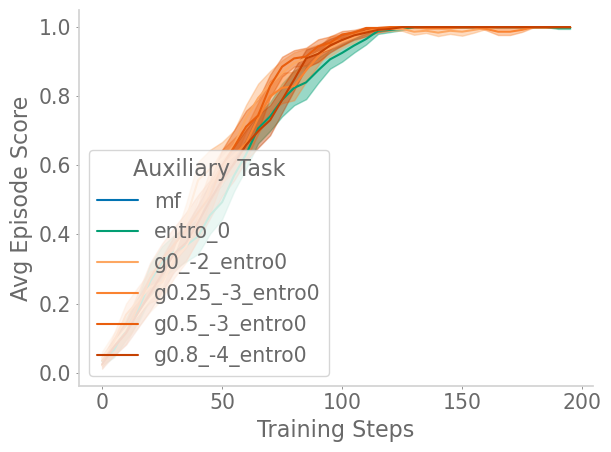

In [157]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])]
new_df = df.copy()
smooth_line = True
new_df['episode'] = new_df['episode']//5*5
episodes = np.unique(new_df['episode'])
fig, ax = plt.subplots()
for _idx, model in enumerate(
    #np.unique(new_df['model'])
    ['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0']
    #['mf_2', 'mf_-1', 'mf', 'mf_1', 'mf_2', 'mf_3']
    ):
    means = []
    sems = []
    for ep in episodes:
        vals = new_df[(new_df['model']==model) & (new_df['episode']==ep)]
        vals = vals['valid_score']
        means.append(np.mean(vals))
        sems.append(sem(vals))
    means = np.array(means)
    sems = np.array(sems)
    mean_lowerbound = means - sems
    mean_upperbound = means + sems
    if smooth_line:
        means = smooth(episodes, means, 3)
        mean_lowerbound = smooth(episodes, mean_lowerbound)
        mean_upperbound = smooth(episodes, mean_upperbound)
    ax.plot(episodes[:-1], means[:-1], label=model, color=colors[_idx])
    ax.fill_between(
        episodes[:-1], mean_lowerbound[:-1],
        mean_upperbound[:-1], alpha=0.4, color=colors[_idx])
plt.ylabel('Avg Episode Score')
plt.xlabel('Training Steps')
plt.legend(title='Auxiliary Task', loc='lower left')
plt.tight_layout()
plt.savefig('foraging.png', dpi=300, transparent=True)
plt.show()